In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import ImageFolder


In [2]:
data_root = "./data/Tesla/"

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),  # 調整影像大小為32x32
    transforms.ToTensor(),  # 將影像轉換為Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 正規化
])

In [4]:
train_dataset = ImageFolder(root=data_root + 'Train', transform=preprocess)
val_dataset = ImageFolder(root=data_root + 'Val', transform=preprocess)
test_dataset = ImageFolder(root=data_root + 'Test', transform=preprocess)


In [5]:
# 建立資料載入器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

c:\Users\Takodachi\anaconda3\envs\torch\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


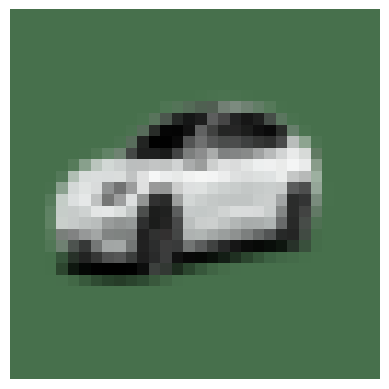

In [6]:
image, label = train_dataset[0]
# 將影像轉換為NumPy數組
image = image.numpy()

# 反正規化影像（取消正規化）
image = image * 0.5 + 0.5

# 顯示影像
plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')
plt.show()


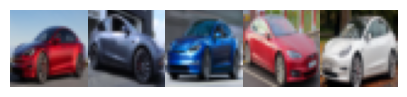

In [7]:
# 選擇要展示的影像的索引範圍
start_index = 0
end_index = start_index + 5

# 創建子圖（5x1）
fig, axes = plt.subplots(1, 5, figsize=(5, 10))

# 選擇資料集

dataset = test_dataset

# 逐一顯示影像
for i, ax in enumerate(axes):
    image, _ = test_dataset[start_index + i]
    image = image.numpy()
    image = image * 0.5 + 0.5
    ax.imshow(image.transpose(1, 2, 0))
    ax.axis('off')

# 調整子圖間的間距
plt.subplots_adjust(wspace=0, hspace=0)

# 顯示圖片
plt.show()

In [8]:
class_names = ['Model3', 'cybertruck']
img, label = train_dataset[5]
img, label, class_names[label]

(tensor([[[ 0.2078,  0.3020,  0.3725,  ..., -0.4196, -0.2941,  0.0353],
          [ 0.2000,  0.0745,  0.2471,  ..., -0.4824, -0.4824, -0.4431],
          [ 0.3961,  0.3412,  0.3333,  ..., -0.5294, -0.5373, -0.5529],
          ...,
          [-0.4667, -0.5373, -0.6157,  ..., -0.6078, -0.6078, -0.6078],
          [-0.4510, -0.4902, -0.5608,  ..., -0.6157, -0.6157, -0.6078],
          [-0.4353, -0.4588, -0.4902,  ..., -0.5922, -0.5765, -0.5843]],
 
         [[ 0.0118,  0.1059,  0.2000,  ..., -0.3333, -0.2235,  0.0745],
          [ 0.0118, -0.1451,  0.0510,  ..., -0.3882, -0.3804, -0.3490],
          [ 0.2392,  0.1765,  0.1686,  ..., -0.4353, -0.4353, -0.4510],
          ...,
          [-0.4667, -0.5294, -0.6078,  ..., -0.5686, -0.5608, -0.5608],
          [-0.4431, -0.4902, -0.5608,  ..., -0.5686, -0.5686, -0.5608],
          [-0.4353, -0.4510, -0.4902,  ..., -0.5451, -0.5294, -0.5373]],
 
         [[-0.1529, -0.0431,  0.0902,  ..., -0.1059, -0.0196,  0.2078],
          [-0.1216, -0.2863,

In [9]:
train_classes = train_dataset.classes
test_classes = test_dataset.classes
print(test_classes)

['Model3', 'cybertruck']


In [10]:
label_map = {0: 0, 1: 1}
class_names = ['Model3', 'cybertruck']
tesla = [(img, label_map[label])
          for img, label in train_dataset
          if label in [0, 1]]
tesla_val = [(img, label_map[label])
              for img, label in test_dataset
              if label in [0, 1]]

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x))) # 第一層
        out = self.pool2(self.act2(self.conv2(out))) # 第二層
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
img, _ = train_dataset[0]
model = Net()
model(img.unsqueeze(0))

tensor([[0.0016, 0.0558]], grad_fn=<AddmmBackward0>)

In [13]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [14]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [15]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss =loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 4 or epoch % 10 == 0:
            print('{} Epoch {}, Training_loss {}'.format(datetime.datetime.now(), epoch,
                                                        loss_train / len(train_loader)
        
))

In [26]:
train_loader = torch.utils.data.DataLoader(tesla, batch_size=64,
                                        shuffle=True)  # <1>

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(  # <5>
    n_epochs = 1000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-06-09 11:33:28.537563 Epoch 4, Training_loss 0.6975748538970947
2023-06-09 11:33:28.575572 Epoch 10, Training_loss 0.6880249381065369
2023-06-09 11:33:28.637586 Epoch 20, Training_loss 0.672191321849823
2023-06-09 11:33:28.697600 Epoch 30, Training_loss 0.6550050973892212
2023-06-09 11:33:28.765615 Epoch 40, Training_loss 0.634918749332428
2023-06-09 11:33:28.791621 Epoch 50, Training_loss 0.6103962063789368
2023-06-09 11:33:28.805624 Epoch 60, Training_loss 0.5804944634437561
2023-06-09 11:33:28.821627 Epoch 70, Training_loss 0.5449268817901611
2023-06-09 11:33:28.837632 Epoch 80, Training_loss 0.504571795463562
2023-06-09 11:33:28.851634 Epoch 90, Training_loss 0.4613761901855469
2023-06-09 11:33:28.865638 Epoch 100, Training_loss 0.4173516631126404
2023-06-09 11:33:28.878641 Epoch 110, Training_loss 0.37351760268211365
2023-06-09 11:33:28.891644 Epoch 120, Training_loss 0.3307521939277649
2023-06-09 11:33:28.904646 Epoch 130, Training_loss 0.2897203266620636
2023-06-09 11:33:28

In [20]:
import collections


train_loader = torch.utils.data.DataLoader(tesla, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(tesla_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class: cybertruck
Actual class: Model3


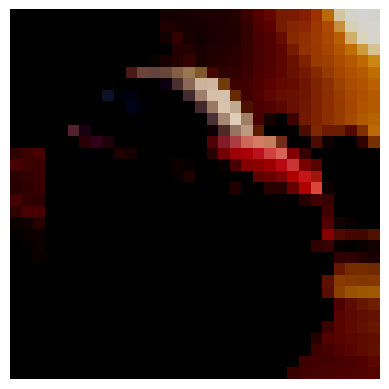

In [25]:
import random

# 從測試集中隨機選擇一張圖片進行預測
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]
image = image.unsqueeze(0)  # 添加一個維度以符合模型輸入的形狀

model.eval()
with torch.no_grad():
    output = model(image.to(device=device))
    _, predicted = torch.max(output, 1)
    predicted_class = train_dataset.classes[predicted.item()]
    actual_class = train_dataset.classes[label]
    print("Predicted class: {}".format(predicted_class))
    print("Actual class: {}".format(actual_class))

# 將圖片轉換回原始形狀並顯示
image = image.squeeze(0)
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()